In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas_datareader import data as pdr
from scipy.optimize import minimize_scalar  
from scipy.interpolate import CubicSpline
from scipy.stats import norm

from datetime import datetime

import yfinance as yf
yf.pdr_override()

from dateutil import parser



In [2]:
class greeks():
    def d(sigma, s, k, r, t):
        d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(s/k) + (r + sigma**2/2) * t)
        d2 = d1 - sigma * np.sqrt(t)
        return d1, d2

    def delta(d1,contract_type):
        if contract_type =='call':
            call_delta= norm.cdf(d1)
            return call_delta
        if contract_type =='put':
            put_delta=-norm.cdf(-d1)
            return put_delta
        
    def gamma(d2,s,k,sigma,r,t):
        gam=(k * np.exp(-r*t)*(norm.pdf(d2)/ (s**2 * sigma * np.sqrt(t) )))
        return gam
    
    def theta(d1,d2,s,k,sigma,r,t,contract_type):
        if contract_type == 'call':
            theta = -s * sigma * norm.pdf(d1)/ (2*np.sqrt(t)) - r *k * np.exp(-r*t) *norm.cdf(d2)
        if contract_type =='put':
            theta = -s * sigma * norm.pdf(-d1)/ (2*np.sqrt(t)) - r *k * np.exp(-r*t) *norm.cdf(-d2)
        return theta/365
    
    def vega(sigma, s,k,r,t):
        d1,d2 = d(sigma, s, k, r, t)
        veg = s * norm.pdf(d1)*np.sqrt(t)
        return veg


In [3]:
def call_price(sigma, s, k, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(s/k) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(s, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * k, np.exp(-r * t))
    return C

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

In [4]:
def allfridays(year):
    return pd.date_range(start=str(year), end=str(year+1),
                         freq='W-FRI').strftime('%Y-%m-%d').tolist()

year_fridays=allfridays(2022)[:52] 




In [5]:
def long_call(S, K, Price):
    P = list(map(lambda x: max(x - K, 0) - Price, S))
    return P
    
def long_put(S, K, Price):
   
    P = list(map(lambda x: max(K - x,0) - Price, S))
    return P
   
def short_call(S, K, Price):
    
    P = long_call(S, K, Price)
    return [-1.0*p for p in P]

def short_put(S,K, Price):
   
    P = long_put(S,K, Price)
    return [-1.0*p for p in P]
    
def binary_call(S, K, Price):
       
    P = list(map(lambda x:  K - Price if x > K else 0 - Price, S))
    return P

def binary_put(S,K, Price):      
    P = list(map(lambda x:  K - Price if x < K else 0 - Price, S))
    return P 

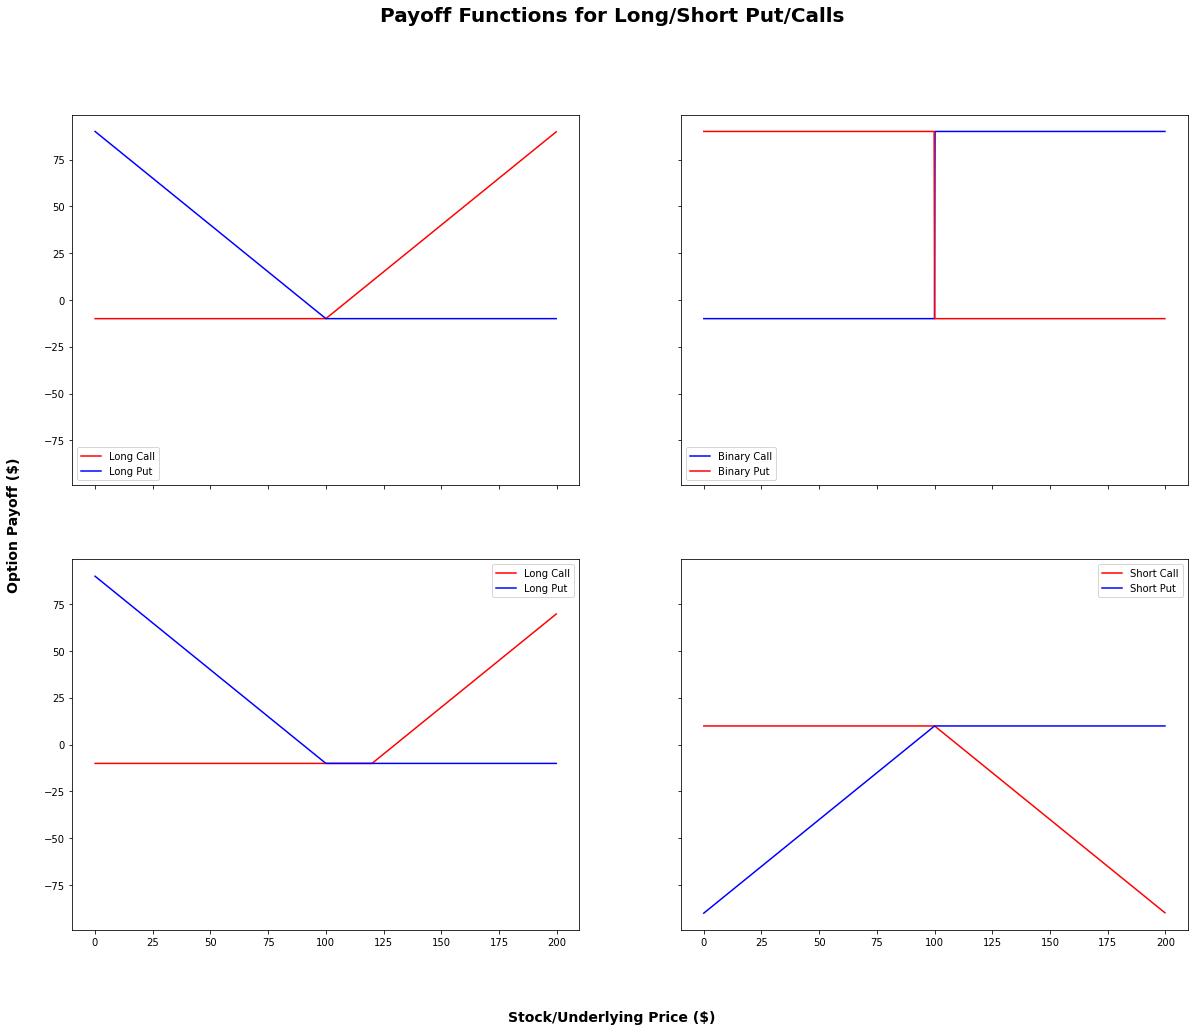

In [28]:
S = [t/5 for t in range(0,1000)] # Define some series of stock-prices 
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize = (20,15))
fig.suptitle('Payoff Functions for Long/Short Put/Calls', fontsize=20, fontweight='bold')
fig.text(0.5, 0.04, 'Stock/Underlying Price ($)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.08, 0.5, 'Option Payoff ($)', va='center', rotation='vertical', fontsize=14, fontweight='bold')


lc_P = long_call(S,100, 10)
lp_P = long_put(S,100, 10)
plt.subplot(221)
plt.plot(S, lc_P, 'r')
plt.plot(S, lp_P, 'b')
plt.legend(["Long Call", "Long Put"])


bc_P = binary_call(S,100, 10)
bp_P = binary_put(S,100, 10)
plt.subplot(222)
plt.plot(S, bc_P, 'b')
plt.plot(S, bp_P, 'r')
plt.legend(["Binary Call", "Binary Put"])

T2 = long_call(S, 120, 10)
T4 = long_put(S,100, 10)
plt.subplot(223)
plt.plot(S,T2, 'r')
plt.plot(S, T4, 'b')
plt.legend(["Long Call", "Long Put"])


sc_P = short_call(S,100, 10)
sp_P = short_put(S,100, 10)
plt.subplot(224)
plt.plot(S, sc_P, 'r')
plt.plot(S, sp_P, 'b')
plt.legend(["Short Call", "Short Put"])

plt.show()

In [29]:
def bull_spread(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = short_call(S, E2, Price2)
    return [x+y for x,y in zip(P_1, P_2)] 
     
def bear_spread(S, E1, E2, Price1, Price2):
    
    P = bull_spread(S,E1, E2, Price1, Price2)
    return [-1.0*p + 1.0 for p in P] 

def straddle(S, E, Price1, Price2):
    
    P_1 = long_call(S, E, Price1)
    P_2 = long_put(S, E, Price2)
    return [x+y for x,y in zip(P_1, P_2)]
    
def risk_reversal(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = short_put(S,E2, Price2)
    return [x + y for x, y in zip(P_1, P_2)]

def strangle(S, E1, E2, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_put(S, E2, Price2)
    return [x + y for x, y in zip(P_1, P_2)]


def butterfly_spread(S, E1, E2, E3, Price1, Price2, Price3):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_call(S, E3, Price3)
    P_3 = short_call(S, E2, Price2)
    P_3 =[2*p for p in P_3]
    return [x + y + z for x, y, z in zip(P_1, P_2, P_3)]
    
def strip(S, E1, Price1, Price2):
    
    P_1 = long_call(S, E1, Price1)
    P_2 = long_put(S, E1, Price2)
    P_2 = [2*p for p in P_2]
    return [x+y for x,y in zip(P_1, P_2)]

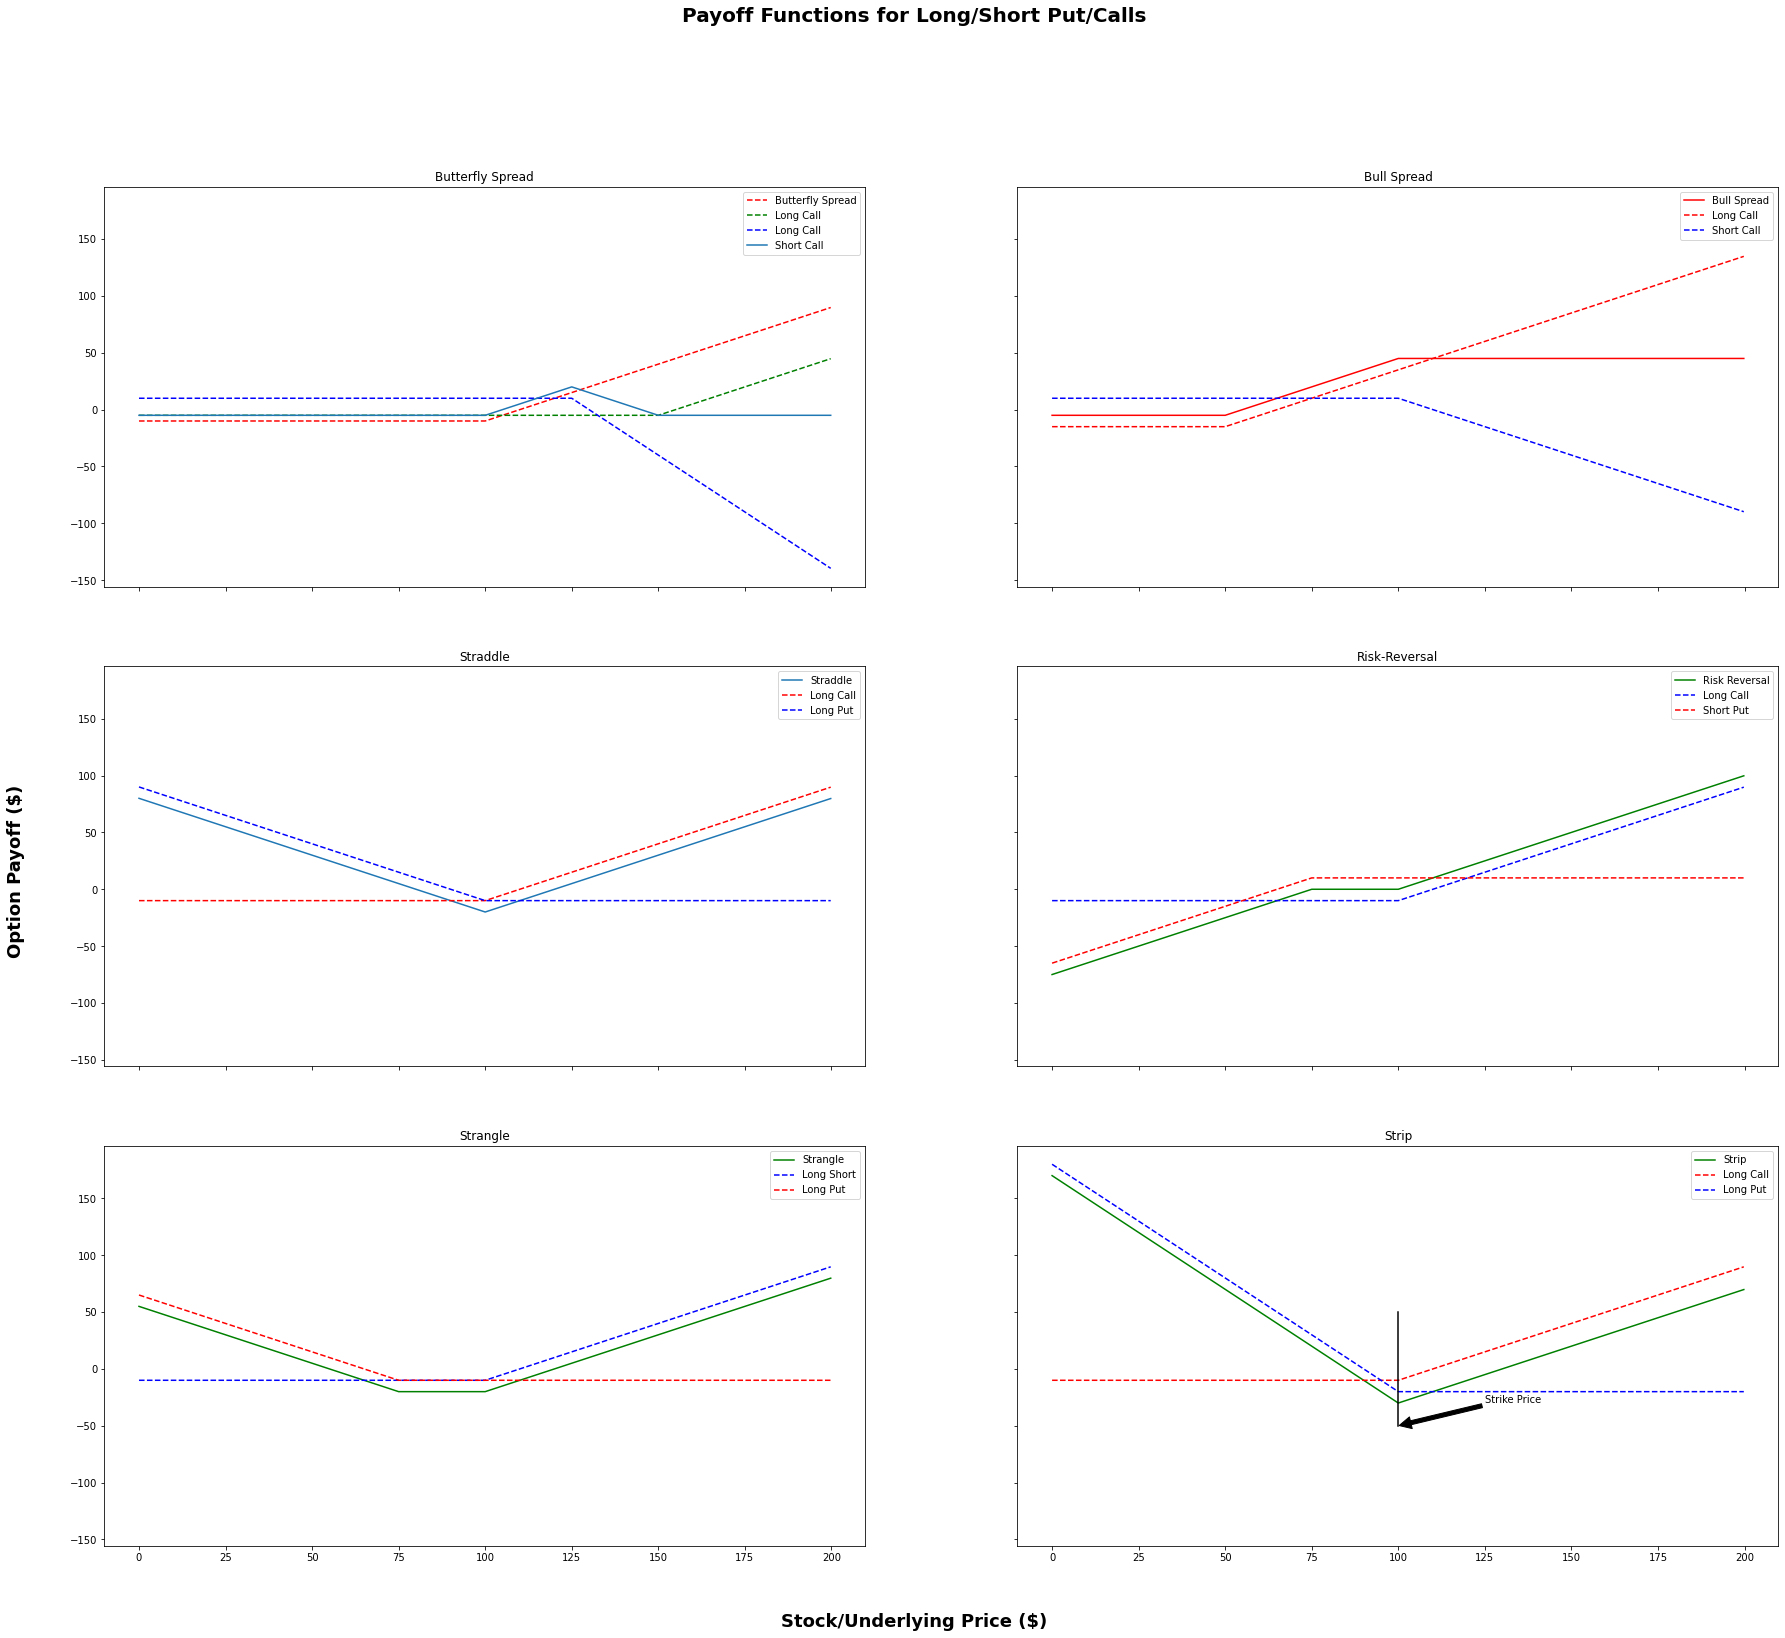

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 25))
fig.suptitle('Payoff Functions for Long/Short Put/Calls', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')
fig.text(0.08, 0.5, 'Option Payoff ($)', va='center', rotation='vertical', fontsize=18, fontweight='bold')

plt.subplot(321)
P = butterfly_spread(S, 100, 125, 150, 10, 5, 5)
P_1 = long_call(S, 100, 10)
P_2 = long_call(S, 150, 5)
P_3 = short_call(S, 125, 5)
P_3 =[2*p for p in P_3]
plt.plot(S, P_1, 'r--')
plt.plot(S, P_2, 'g--')
plt.plot(S, P_3, 'b--')
plt.plot(S, P)
plt.legend(["Butterfly Spread", "Long Call", "Long Call", "Short Call"])
plt.title("Butterfly Spread")

plt.subplot(322)
P1 = bull_spread(S,50, 100, 15, 10)
long_c = long_call(S, 50, 15)
short_c = short_call(S, 100, 10)
    
plt.plot(S, P1, 'r')
plt.plot(S, long_c, 'r--')
plt.plot(S, short_c, 'b--')

plt.legend(["Bull Spread", "Long Call", "Short Call"])
plt.title("Bull Spread")

plt.subplot(323)
P = straddle(S,100, 10, 10)
P_longcall = long_call(S, 100, 10)
P_longput = long_put(S, 100, 10)
plt.plot(S, P) 
plt.plot(S, P_longcall, 'r--')
plt.plot(S, P_longput, 'b--')
plt.legend(["Straddle", "Long Call", "Long Put"])
plt.title("Straddle")

plt.subplot(324)
P = risk_reversal(S,100,75, 10, 10)
P_longcall = long_call(S, 100, 10)
P_shortput = short_put(S,75, 10)
plt.plot(S, P, 'g')
plt.plot(S, P_longcall, 'b--')
plt.plot(S, P_shortput, 'r--')
plt.legend(["Risk Reversal", "Long Call", "Short Put"])
plt.title("Risk-Reversal")

plt.subplot(325)
P = strangle(S,100, 75, 10, 10)
P_longcall = long_call(S, 100, 10)
P_longput = long_put(S, 75, 10)
plt.plot(S, P, 'g')
plt.plot(S, P_longcall, 'b--')
plt.plot(S, P_longput, 'r--')
plt.legend(["Strangle", "Long Short", "Long Put"])
plt.title("Strangle")

plt.subplot(326)
P_1 = long_call(S, 100, 10)
P_2 = long_put(S, 100, 10)
P_2 = [2*p for p in P_2]
P = strip(S, 100, 10, 10 )
plt.plot(S, P, 'g')
plt.plot(S, P_1, 'r--')
plt.plot(S, P_2, 'b--')
plt.plot([100,100],[-50,50],'black')
plt.legend(["Strip", "Long Call", "Long Put"])
plt.annotate('Strike Price', 
            xy=(100, -50), 
            xytext=(125, -30), 
            arrowprops = dict(facecolor='black', shrink=0.01))
plt.title("Strip")

plt.show()

C:\Users\Dan\AppData\Local\Temp/ipykernel_20976/4290735733.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(s/k) + (r + sigma**2 / 2.) * t  )
C:\Users\Dan\AppData\Local\Temp/ipykernel_20976/4290735733.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(S/K) + (r + sigma**2 / 2.) * t  )


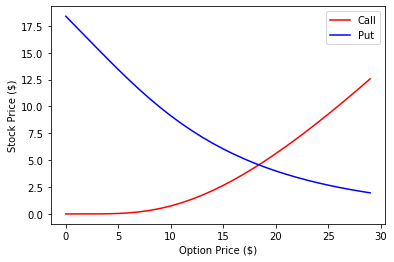

In [11]:
S = np.arange(0, 30)
vals_call = [call_price(.2, x, 50, 0.10, 10) for x in S]
vals_put = [put_price(.2, x, 50, 0.10, 10) for x in S]
plt.plot(S,vals_call, 'r', label = "Call")
plt.plot(S, vals_put, 'b', label  = "Put")
plt.legend()
plt.ylabel("Stock Price ($)")
plt.xlabel("Option Price ($)")
plt.show()

In [12]:
def d1_calc(S, K, r, vol, T, t):
    # Calculates d1 in the BSM equation     
    return (np.log(S/K) + (r + 0.5 * vol**2)*(T-t))/(vol*np.sqrt(T-t))

def delta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    
    if(otype == "call"):
        delta = np.exp(-(T-t))*norm.cdf(d1)
    elif(otype == "put"):
        delta = -np.exp(-(T-t))*norm.cdf(-d1)

    return delta

# Gamma for calls/puts the same 
def vega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return S * norm.pdf(d1) * np.sqrt(T-t)

def rho(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        rho = K*(T-t)*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        rho = -K*(T-t)*np.exp(-r*(T-t))*norm.cdf(-d2)
    return rho

def theta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) - r*K*np.exp(-r*(T-t))*norm.cdf(d2) 
    elif(otype == "put"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) + r*K*np.exp(-r*(T-t))*norm.cdf(-d2)

    return theta

def gamma(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    gamma = (norm.pdf(d1)) / (S * vol * np.sqrt(T-t))
    
    return gamma

def charm(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    charm = -norm.pdf(d1)*(2*r*(T-t) - d2*vol*np.sqrt(T-t))/(2*(T-t)*vol*np.sqrt(T-t))


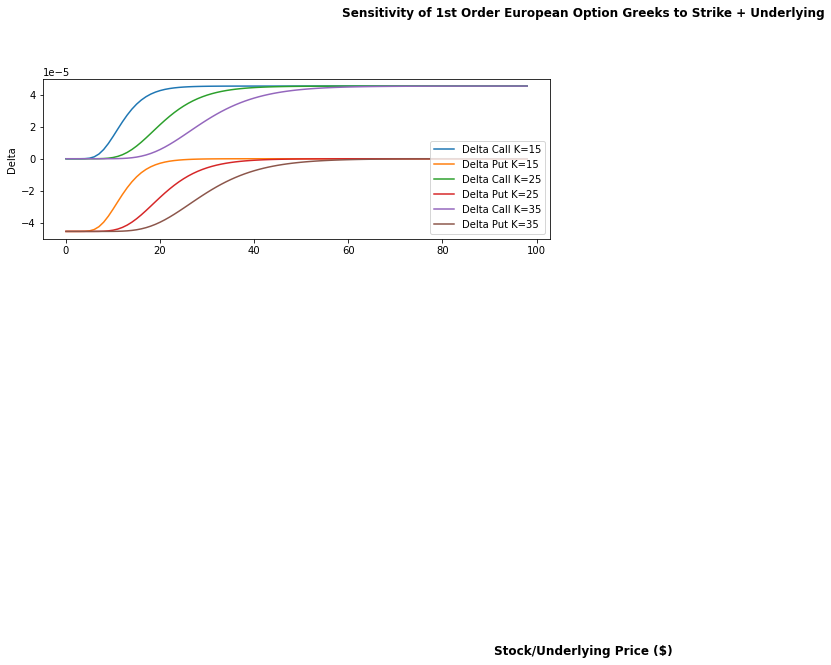

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
vals = [15,25,35]

r = 0.01
vol = 0.1
T = 10
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Delta Put K=%i" % i ))

plt.ylabel("Delta")
plt.legend()



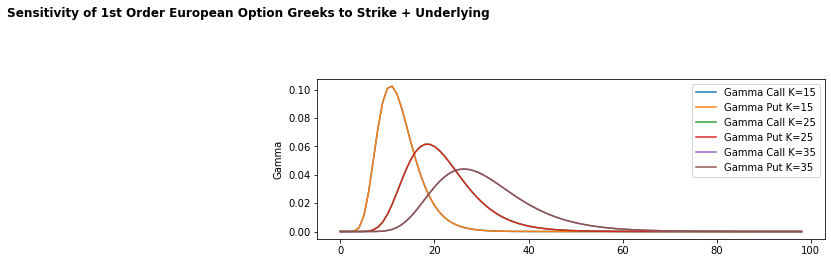

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
#fig.text(0.2, 0.05, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
vals = [15,25,35]
plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Gamma Put K=%i" % i ))

plt.ylabel("Gamma")
plt.legend()

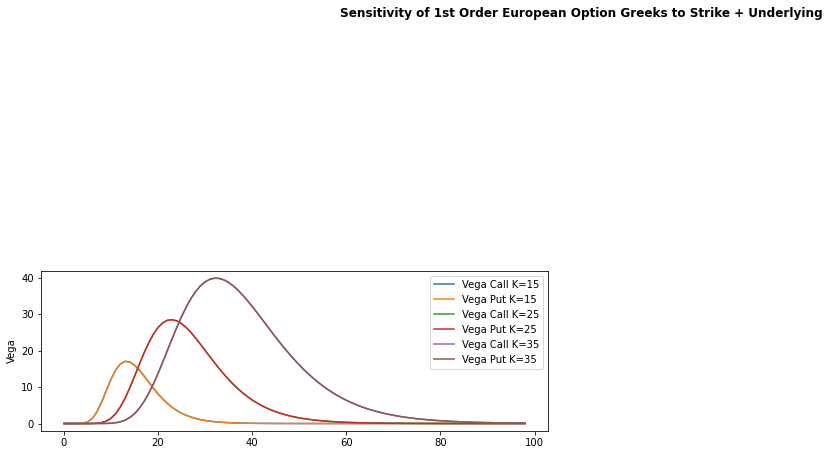

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
#fig.text(0.2, 0.05, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
vals = [15,25,35]
plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Vega Put K=%i" % i ))

plt.ylabel("Vega")
plt.legend()


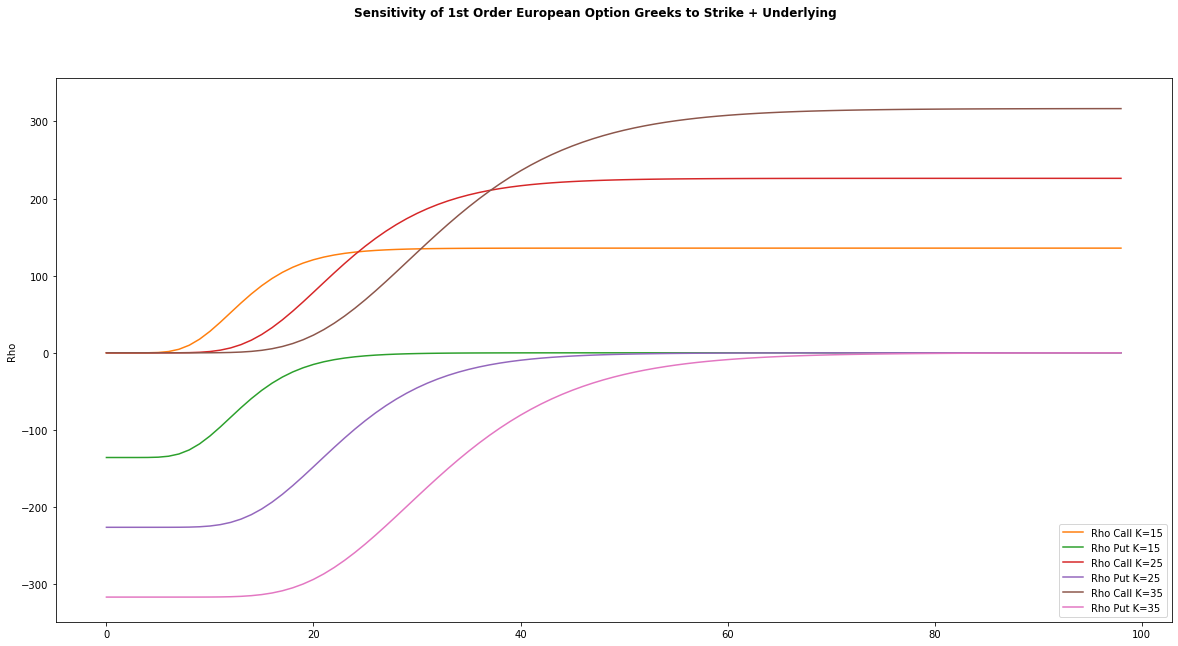

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
#fig.text(0.2, 0.05, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
vals = [15,25,35]
plt.plot(324)

for i in vals:
    tmp_c = [rho(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Rho Put K=%i" % i ))

plt.ylabel("Rho")
plt.legend()


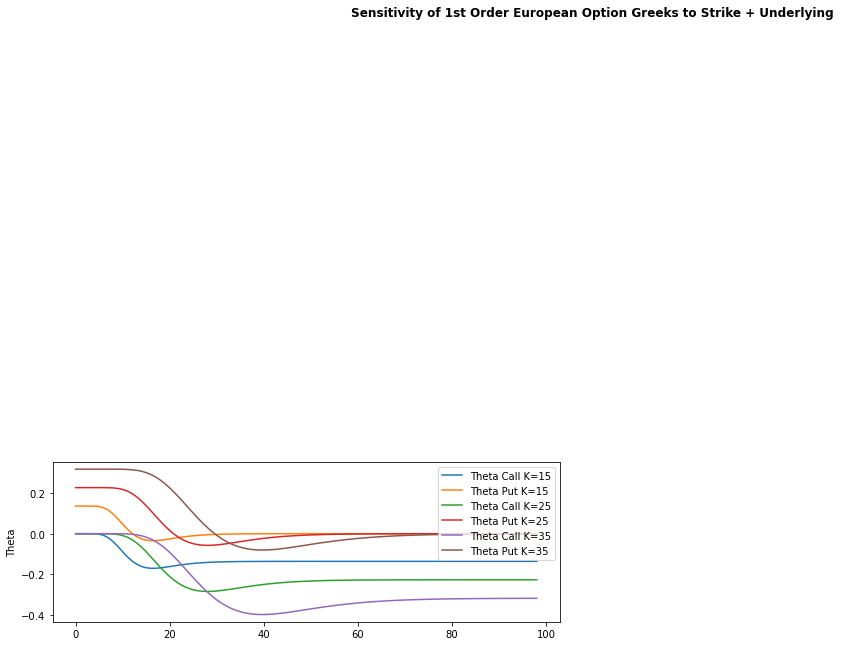

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
#fig.text(0.2, 0.05, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Theta Put K=%i" % i ))

plt.ylabel("Theta")
plt.legend()

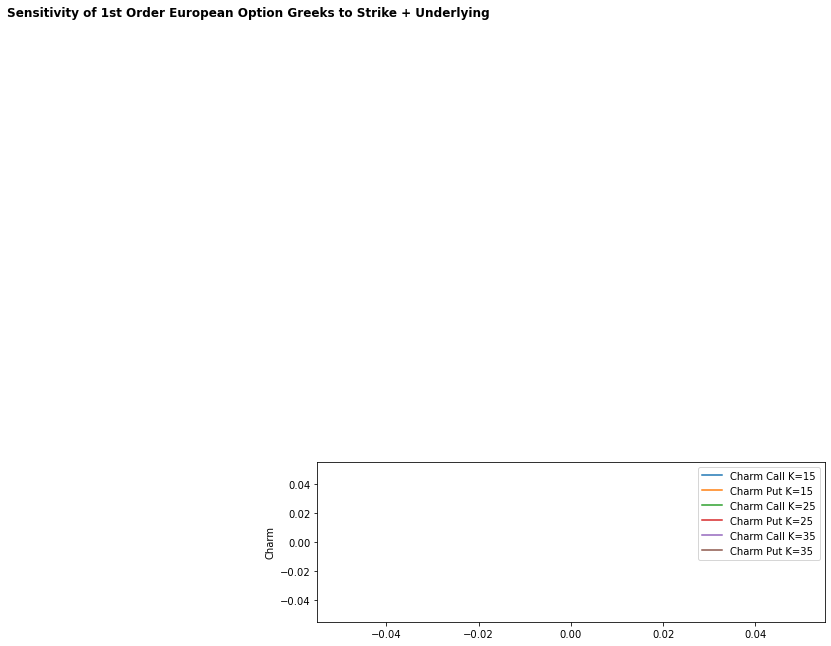

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=12, fontweight='bold')
#fig.text(0.2, 0.05, 'Stock/Underlying Price ($)', ha='center', fontsize=12, fontweight='bold')
vals = [15,25,35]

r = 0.01
vol = 0.1
T = 10
t = 0


plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Charm Put K=%i" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

In [70]:
#https://clinthoward.github.io/portfolio/2017/04/16/BlackScholesGreeks/

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def greeks_plot_tool(greek_function, x_var_name, y_var_name,
                     S, K, r, vol, T, t, x, y, otype, plot):
    
   
    # Initialise vector to store our option values and then iterate over     # Assumption that we're using a constant sized vector length for each variable     # Need to change the variables being iterated over here for each update (possibly a better way to do this)  
    
    V = np.zeros((len(S), len(S)), dtype=np.float)
    for i in range(len(S)):
        for j in range(len(S)):
            V[i, j] = greek_function(S[i], K[i], r[i], vol[i], T[j], t[i], otype)
 
    # Initiliase plotting canvas 
    surf = plot.plot_surface(x, y, V, rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
    plot.set_xlabel('\n' + x_var_name, linespacing=4)
    plot.set_ylabel('\n' + y_var_name, linespacing=4)
    plot.set_zlabel("%s(K, T)" % greek_function.__name__)
    plot.set_title("%s %s" % (otype, greek_function.__name__))
    
    Vlevels = np.linspace(V.min(),V.max(),num=8,endpoint=True)
    xlevels = np.linspace(x.min(),x.max(),num=8,endpoint=True)
    ylevels = np.linspace(y.min(),y.max(),num=8,endpoint=True)
    
    cset = plot.contourf(x, y, V, Vlevels, zdir='z',offset=V.min(),
                         cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, xlevels, zdir='x',offset=x.min(),
                         cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, ylevels, zdir='y',offset=y.max(),
                         cmap=cm.RdYlBu,linestyles='dashed')

    for c in cset.collections:
        c.set_dashes([(0, (2.0, 2.0))]) # Dash contours 
    plt.clabel(cset,fontsize=10, inline=1)
    plot.set_xlim(x.min(),x.max())
    plot.set_ylim(y.min(),y.max())
    plot.set_zlim(V.min(),V.max())

    colbar =plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
    l,b,w,h = plt.gca().get_position().bounds
    ll,bb,ww,hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])
    
        
S = np.linspace(70, 140, 40)
K = np.linspace(105.0, 105.0, 40)
T = np.linspace(0.1, 2.0, 40)
t = np.linspace(0.0, 0.0, 40)
r = np.linspace(0.0, 0.0, 40)
vol = np.linspace(0.12, 0.12, 40)

x, y  = np.meshgrid(S, T)

fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]

for i in range(len(greeks)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S, K, r, vol, T, t, x, y, "call", ax)

plt.show()

C:\Users\Dan\AppData\Local\Temp/ipykernel_18584/1239139237.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  V = np.zeros((len(S), len(S)), dtype=np.float)


ValueError: not enough values to unpack (expected 3, got 0)

AttributeError: 'Poly3DCollection' object has no attribute '_vec'

<Figure size 2160x1440 with 7 Axes>

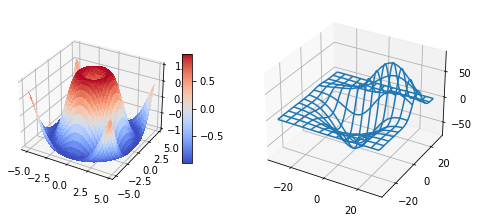

In [82]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
X, Y, Z = get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [88]:
S = np.linspace(70, 140, 40)
K = np.linspace(105.0, 105.0, 40)
T = np.linspace(0.1, 2.0, 40)
t = np.linspace(0.0, 0.0, 40)
r = np.linspace(0.0, 0.0, 40)
vol = np.linspace(0.12, 0.12, 40)

x, y  = np.meshgrid(S, T)
fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]
plt.show()

fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]

for i in range(len(greeks)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S, K, r, vol, T, t, x, y, "call", ax)

plt.show()

<Figure size 2160x1440 with 0 Axes>

C:\Users\Dan\AppData\Local\Temp/ipykernel_18584/1239139237.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  V = np.zeros((len(S), len(S)), dtype=np.float)


ValueError: not enough values to unpack (expected 3, got 0)

AttributeError: 'Poly3DCollection' object has no attribute '_vec'

<Figure size 2160x1440 with 7 Axes>